## Preprocessing de features pour la seconde itération

#### Table Clients
- Pourcentage d'achat dans chaque catégorie (par ex 70% de vêtements pour femme, 30% divers)
- Découpage de l'âge en tranche
- Pourcentage d'achats d'articles déjà achetés une fois
- Durée moyenne entre chaque rachat d'un même article
- Groupe de code postal (voir `postal_code_groups.ipynb`)
- Clusterisation

#### Table Articles 
- Pourcentage d'achats par un client qui a déjà acheté l'article une fois (= rachat)
- Durée moyenne entre chaque rachat
- Pourcentage d'achat pour chaque tranche d'âge (ex 50% des achats de cet article sont faits par des 20-30 ans)

In [2]:
import pandas as pd
import numpy as np

In [12]:
# Chargement des tables
transactions = pd.read_pickle("pickles/transactions.pkl")
customers = pd.read_pickle("pickles/customers_clean.pkl")
articles = pd.read_pickle("pickles/articles_clean.pkl")

### Pourcentage d'achat dans chaque catégorie / rachats d'article

In [13]:
customer_purchases = transactions[['customer_id', 'article_id', 'week_number']].groupby(['customer_id', 'article_id'], as_index = False).agg(
    purchases = ('article_id', 'count'),
    first_purchase_day = ('week_number', 'min'),
    last_purchase_day = ('week_number', 'max'),
)

In [5]:
def merge_by_chunks(dataframe_left, dataframe_right, on, how, rows_by_chunk = 1000000):
    """Merge two dataframe by parts, in cutting the left one in chunks.

    Args:
        dataframe_left (_type_): _description_
        dataframe_right (_type_): _description_
        on (_type_): _description_
        how (_type_): _description_
        rows_by_chunk (int, optional): _description_. Defaults to 1 000 000.
    """
    chunks = []
    
    nb_chunks = np.ceil(len(dataframe_left) // rows_by_chunk).astype(int)
    print(nb_chunks)
    
    for i in range(0, nb_chunks):
        row_start = rows_by_chunk * i
        row_end = np.amin([rows_by_chunk * (i + 1), len(dataframe_left)]) - 1
        
        print(f"Mergin from row {row_start} to {row_end}")
        
        dataframe_left.iloc[row_start:row_end] = dataframe_left.iloc[row_start:row_end].merge(dataframe_right, on = on, how = how)
        
        
    return dataframe_left
        

In [ ]:
articles.head()
article_to_merge = articles[['article_id', 'index_group_name']]
article_to_merge['index_group_name'] = article_to_merge['index_group_name'].str.lower()
index_dummies = pd.get_dummies(article_to_merge['index_group_name'], prefix='', prefix_sep='')
article_to_merge = pd.concat([article_to_merge, index_dummies], axis = 1)
article_to_merge.drop('index_group_name', 1, inplace=True)

In [15]:
customer_purchases = customer_purchases.merge(article_to_merge, how = 'left', on ='article_id')

In [16]:
customer_purchases['repurchases'] = customer_purchases['purchases'] - 1

In [17]:
customer_purchases['repurchase_interval'] = np.where(
    customer_purchases['repurchases'] != 0, 
    (customer_purchases['last_purchase_day'] - customer_purchases['first_purchase_day']) / customer_purchases['repurchases'], 
    0
)

In [20]:
customer_purchases.to_pickle('pickles/customer_purchases.pkl')

In [19]:
# Mettre à jour les dummies de catégorie pour tenir compte du nombre d'achat
customer_purchases['baby/children'] = customer_purchases['baby/children'] * customer_purchases['purchases']
customer_purchases['divided'] = customer_purchases['divided'] * customer_purchases['purchases']
customer_purchases['ladieswear'] = customer_purchases['ladieswear'] * customer_purchases['purchases']
customer_purchases['menswear'] = customer_purchases['menswear'] * customer_purchases['purchases']
customer_purchases['sport'] = customer_purchases['sport'] * customer_purchases['purchases']

In [7]:
customers_features = customer_purchases.groupby('customer_id', as_index = False).agg(
    baby = ('baby/children', 'sum')	,
    divided = ('divided', 'sum')	,
    ladieswear = ('ladieswear', 'sum')	,
    menswear = ('menswear', 'sum')	,
    sport = ('sport', 'sum'),
    total = ('purchases', 'sum'),
    repurchases = ('repurchases', 'sum'),
    repurchases_interval = ('repurchase_interval', 'sum')
)

In [8]:
# Finalisation des nouvelles features

# Exprimer chaque catégorie en pourcentage du total
customers_features['baby'] = customers_features['baby'] / customers_features['total']
customers_features['divided'] = customers_features['divided'] / customers_features['total']
customers_features['ladieswear'] = customers_features['ladieswear'] / customers_features['total']
customers_features['menswear'] = customers_features['menswear'] / customers_features['total']
customers_features['sport'] = customers_features['sport'] / customers_features['total']

# Finaliser le calcul de l'intervalle moyen entre deux rachats
customers_features['repurchases_interval'] = np.where(
    customers_features['repurchases'] != 0, 
    customers_features['repurchases_interval'] / customers_features['repurchases'],
    0
)

# Suppression du total d'articles car on l'a déjà dans la table des Clients.
customers_features.drop('total', 1, inplace=True)

/tmp/ipykernel_17430/3545306709.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  customers_features.drop('total', 1, inplace=True)


In [9]:
customers = pd.read_pickle('pickles/customers_clean.pkl')
customers = customers.merge(customers_features, how = 'left', on = 'customer_id')

In [15]:
# Ajout des tranches d'âges
ages = [15, 25, 35, 45, 55, 65]

for age in ages:
    customers[f'age_around_{age}'] = 1 - np.abs(customers['age'] - age) / 10
    customers[f'age_around_{age}'].clip(0, 1, inplace = True)
    


In [3]:
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')

In [5]:
postal_code_groups = pd.read_pickle('pickles/postal_code_groups.pkl')
customers = customers.merge(postal_code_groups, on="postal_code", how = "left")

In [13]:
# Mise à jour des formats des nouveaux champs. (+ nettoyage)
int_fields = ['FN', 'Active', 'age', 'total_carts', 'total_articles', 'repurchases', 'postal_code_group']
float_fields = ['age', 'postal_code', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases_interval', 'age_around_15',
       'age_around_25', 'age_around_35', 'age_around_45', 'age_around_55',
       'age_around_65']

customers[int_fields] = customers[int_fields].fillna(0).astype(int)

#### Clusterisation des Client

In [3]:
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')

In [4]:
features_list = ['FN', 'Active', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases', 'repurchases_interval', 'age_around_15',
       'age_around_25', 'age_around_35', 'age_around_45', 'age_around_55',
       'age_around_65']

cluster_features = customers[features_list].fillna(0)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(cluster_features)

In [5]:
# Création de données de validation pour évaluer la clusterisation
last_week_sales = transactions[transactions['week_number'] == 0][['customer_id', 'article_id']]

validation_data = last_week_sales.groupby(['customer_id'], as_index = False).agg(
    purchased_articles = ('article_id', lambda x: list(x))
)

In [ ]:
# Initialisation des Clusters
from sklearn.cluster import KMeans
from utils.map12_from_series import map12_from_series

# Recherche du nombre de clusters qui donnera le meilleur score MAP@12
score_curve = [0.010221290725402028] # Répercussion du score obtenu dans `post_code_groups.ipynb` pour la liste des ventes générale
best_score = 0

customers_group = customers[['customer_id']]
    
for k in range(10, 15):
    
    print(f"\r Entraînement pour {k} clusters                    ", end="")
    model = KMeans(n_clusters=k).fit(X)
    clusters = model.predict(X)
    
    # Process a top sales list for each groups.
    customers_group['group'] = clusters
    
    top_sales_by_group = last_week_sales.merge(customers_group, on ='customer_id', how='left').groupby(
        ['group', 'article_id'],
        as_index = False
    ).agg(
        sales = ('article_id', 'count')
    )
    
    print(f"\r Mise en forme des données                   ", end="")
    
    # Assign the lists to each postal code
    top_sales_lists = {}
    for group in range(0, k + 1):
        top_sales_lists[group] = top_sales_by_group.loc[top_sales_by_group['group'] == group].nlargest(12, columns = ['sales'])['article_id'].to_list()
    
    customers_group.loc[:, 'prediction'] = customers_group.loc[:, 'group'].apply(lambda x: top_sales_lists[x])
    
    # Put the prediction aside of the real lists.
    validation_data_with_prediction = validation_data.merge(customers_group, on = 'customer_id', how='left')
    
    print(f"\r Calcul du score pour {k} clusters                 ", end="")
    score = map12_from_series(validation_data_with_prediction['purchased_articles'], validation_data_with_prediction['prediction']).sum() / len(validation_data_with_prediction)
    
    print(f"Score pour {k} clusters: {score}")
    
    if score > best_score:
        best_model = model
        best_clusters = clusters
        
    score_curve.append(score)



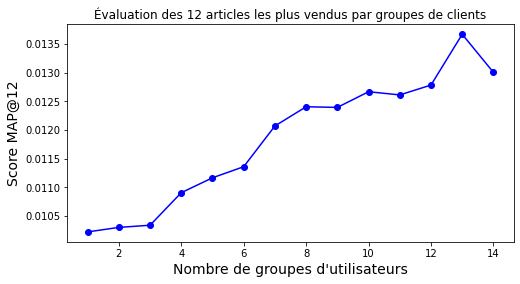

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(1, 15), score_curve, "bo-")
plt.xlabel("Nombre de groupes d'utilisateurs", fontsize=14)
plt.ylabel("Score MAP@12", fontsize=14)
plt.title('Évaluation des 12 articles les plus vendus par groupes de clients')
plt.show()

In [16]:
# Partons sur 8 clusters
model = KMeans(n_clusters=8).fit(X)
clusters = model.predict(X)

# Récupération et affichage des centroïdes.
centroids_values = scaler.inverse_transform(model.cluster_centers_)
centroids = pd.DataFrame(centroids_values, columns=features_list)
centroids

,FN,Active,average_cart_articles,average_cart_price,total_carts,total_articles,total_price,average_cart_interval,baby,divided,...,menswear,sport,repurchases,repurchases_interval,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65
0,0.014534,4.085621e-14,2.462669,0.062855,2.623308,7.502217,0.167368,6.011513,0.007841,0.805694,...,0.027092,0.017476,0.304987,0.602433,2.665719e-01,4.471127e-01,1.029732e-01,6.998093e-02,7.406669e-02,2.808807e-02
1,0.007881,5.007106e-14,3.185092,0.086406,6.448784,23.071725,0.572666,8.769610,0.014328,0.158934,...,0.060016,0.048030,0.991770,1.586284,1.766990e-01,7.351748e-01,8.812627e-02,-4.204970e-14,-2.828293e-14,-1.942890e-15
2,1.000000,9.860329e-01,3.633398,0.095392,8.512467,33.271078,0.823149,8.838860,0.107889,0.179205,...,0.054019,0.040720,1.752470,2.147584,1.161571e-14,1.738168e-01,6.854216e-01,1.407616e-01,-7.993606e-15,-1.720846e-15
3,1.000000,9.960863e-01,2.891173,0.081747,8.772347,27.513223,0.718455,9.070135,0.054769,0.184561,...,0.068392,0.034408,1.494510,1.836380,7.993606e-16,4.685141e-14,1.883711e-02,3.436771e-01,4.281111e-01,1.637206e-01
4,0.008793,4.629630e-14,2.831832,0.085661,5.832521,18.217685,0.492215,8.330061,0.026294,0.126804,...,0.068998,0.039425,0.877708,1.284340,4.234113e-15,4.274359e-14,2.883804e-14,1.147685e-01,5.981962e-01,2.335770e-01
5,0.004623,4.618528e-14,3.756522,0.104057,5.790731,23.875901,0.606068,8.477816,0.096541,0.133023,...,0.053501,0.048622,1.114131,1.648697,5.270784e-15,1.921396e-01,7.271445e-01,8.071592e-02,2.095546e-14,-1.873501e-15
6,1.000000,9.869059e-01,2.930400,0.076017,8.501121,27.835531,0.671863,9.460314,0.015769,0.279347,...,0.056698,0.037598,1.300670,1.901105,2.450968e-01,6.892877e-01,6.561558e-02,-2.439715e-14,3.008704e-14,-1.901257e-15
7,0.012062,4.402034e-14,3.388339,0.092289,5.887963,21.445795,0.535008,8.588573,0.145919,0.175536,...,0.074503,0.050533,0.966101,1.510596,1.550010e-14,1.415534e-14,9.891524e-02,7.326717e-01,1.626614e-01,1.106368e-03


In [17]:
customers['group'] = clusters

#### Groups de code postaux
Voir `postal_code_groups.ipynb`

In [2]:
postal_code_groups = pd.read_pickle('pickles/postal_code_groups.pkl')

In [4]:
customers = customers.merge(postal_code_groups, on = 'postal_code', how = 'left')

In [8]:
customers.drop(columns = 'postal_code', axis = 1, inplace = True)

Sauvegarde finale

In [9]:
customers.to_pickle('pickles/customers_second_iteration.pkl')

In [10]:
customers.head(5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,average_cart_articles,average_cart_price,total_carts,total_articles,...,repurchases,repurchases_interval,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,postal_code_group,group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,NONE,49,1.900000,0.054393,10,21,...,0,0.000000,0.0,0.0,0.0,0.6,0.4,0.0,4,7
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,NONE,25,3.250000,0.100510,24,86,...,14,5.285714,0.0,1.0,0.0,0.0,0.0,0.0,4,1
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,NONE,24,2.142857,0.086646,7,18,...,1,0.000000,0.1,0.9,0.0,0.0,0.0,0.0,4,1
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,NONE,54,2.000000,0.060983,1,2,...,0,0.000000,0.0,0.0,0.0,0.1,0.9,0.0,1,4
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,Regularly,52,2.166667,0.078282,6,13,...,1,2.000000,0.0,0.0,0.0,0.3,0.7,0.0,1,3


### Features de la table Articles

In [1]:
### CHECKPOINT

import pandas as pd

customer_purchases = pd.read_pickle('pickles/customer_purchases.pkl')

In [2]:
article_purchases = customer_purchases[['customer_id','article_id','purchases','first_purchase_day','last_purchase_day', 'repurchases', 'repurchase_interval']]

In [8]:
article_purchases.to_pickle('pickles/article_purchases.pkl')

In [ ]:
customers_features = pd.read_pickle('pickles/customers_second_iteration.pkl')

In [ ]:
customers_features = customers_features.drop(['FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'baby', 'divided', 'ladieswear', 'menswear',
       'sport', 'repurchases', 'repurchases_interval'], 1)

In [6]:
article_purchases = article_purchases.merge(customers_features, how = 'left', on = 'customer_id')

In [7]:
article_purchases.to_pickle('pickles/article_purchases.pkl')

In [ ]:
# Mise à jour du coefficient par âge en fonction des ventes
article_purchases['age_around_15'] = article_purchases['age_around_15'] * article_purchases['purchases']
article_purchases['age_around_25'] = article_purchases['age_around_25'] * article_purchases['purchases']
article_purchases['age_around_35'] = article_purchases['age_around_35'] * article_purchases['purchases']
article_purchases['age_around_45'] = article_purchases['age_around_45'] * article_purchases['purchases']
article_purchases['age_around_55'] = article_purchases['age_around_55'] * article_purchases['purchases']
article_purchases['age_around_65'] = article_purchases['age_around_65'] * article_purchases['purchases']

In [20]:
# Groupage par article
article_features = article_purchases.groupby('article_id', as_index = False).agg(
    age_around_15 = ('age_around_15', 'sum'),
    age_around_25 = ('age_around_25', 'sum'),
    age_around_35 = ('age_around_35', 'sum'),
    age_around_45 = ('age_around_45', 'sum'),
    age_around_55 = ('age_around_55', 'sum'),
    age_around_65 = ('age_around_65', 'sum'),
    repurchases = ('repurchases', 'sum'),
    repurchase_interval = ('repurchase_interval', 'sum'),
    total = ('purchases', 'sum')
)

In [21]:
# Finalisation des features
article_features['age_around_15'] = article_features['age_around_15'] / article_features['total']
article_features['age_around_25'] = article_features['age_around_25'] / article_features['total']
article_features['age_around_35'] = article_features['age_around_35'] / article_features['total']
article_features['age_around_45'] = article_features['age_around_45'] / article_features['total']
article_features['age_around_55'] = article_features['age_around_55'] / article_features['total']
article_features['age_around_65'] = article_features['age_around_65'] / article_features['total']
article_features['repurchases'] = article_features['repurchases'] / article_features['total']
article_features['repurchase_interval'] = article_features['repurchase_interval'] / article_features['total']

In [23]:
article_features.to_pickle('pickles/article_features.pkl')

In [28]:
articles = pd.read_pickle('pickles/articles_clean.pkl')

In [30]:
article_features.drop('total', 1, inplace = True)
articles = articles.merge(article_features, on = 'article_id', how = 'left')

In [ ]:
articles.drop([
    'product_code', 'prod_name', 'product_type_no',
        'graphical_appearance_no',
       'colour_group_code',
       'perceived_colour_value_id',
       'perceived_colour_master_id',
       'department_no', 'index_code',
       'index_group_no', 'section_no',
       'garment_group_no', 'detail_desc',
], 1, inplace = True)

In [12]:
articles = pd.read_pickle('pickles/articles_second_iteration.pkl')

In [36]:
articles.to_pickle('pickles/articles_second_iteration.pkl')

In [13]:
articles.head(5)

,article_id,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,...,average_price,has_image,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,repurchases,repurchase_interval
0,0108775015,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,...,0.008109,True,0.048799,0.427950,0.244332,0.128714,0.123305,0.024154,0.086264,8.337149
1,0108775044,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,...,0.008093,True,0.046047,0.397741,0.224785,0.143694,0.144617,0.036216,0.067420,9.584520
2,0108775051,Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,...,0.004982,True,0.048588,0.406215,0.275141,0.114689,0.112994,0.041808,0.050847,0.022599
3,0110065001,Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,...,0.020055,True,0.043075,0.305193,0.208741,0.236167,0.172301,0.031059,0.037678,11.282077
4,0110065002,Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,...,0.018087,True,0.048340,0.268880,0.192832,0.256753,0.195436,0.032573,0.045643,10.160270
